# Imports

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# MNIST Data

In [4]:
X, y = fetch_openml(name='mnist_784', return_X_y=True)

In [5]:
X.shape  # (n_samples, n_features)

(70000, 784)

In [6]:
y.shape # (n_samples) 

(70000,)

In [8]:
y = y.astype(np.int8)  # str 타입을 int 타입으로 변환 
y.dtype

dtype('int8')

In [9]:
X.dtype

dtype('float64')

In [10]:
np.min(X[0])

0.0

In [11]:
np.max(X[0])

255.0

In [12]:
X_scaled = X / 255.0  # 데이터의 값의 범위를 0 ~ 255에서 0 ~ 1 범위로 스케일링 

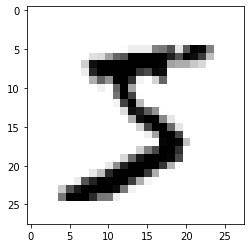

In [13]:
plt.imshow(X_scaled[0].reshape((28, 28)), cmap=plt.cm.binary)
plt.show()

# Train/Test Split

In [14]:
num_train = 60_000 

In [15]:
X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

In [16]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [17]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

# PCA(Principal Component Analysis) 

## MNIST 데이터의 차원을 2차원으로 축소 후 시각화 

In [18]:
pca = PCA(n_components=2)  # PCA 객체 생성

In [19]:
X_train_reduced = pca.fit_transform(X_train)
# fit: 주성분 찾음
# transform: 주성분 방향으로 projectiion (투영) -> 차원 축소

In [20]:
X_train_reduced.shape  # (60_000, 2)

(60000, 2)

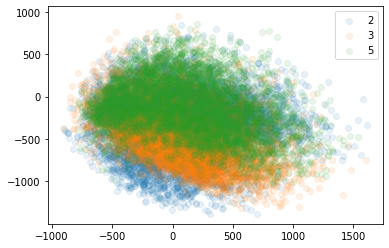

In [23]:
# 훈련 셋에서 숫자 2, 3, 5를 주성분 평면 위에 시각화
for n in (2, 3, 5):
    subset = X_train_reduced[y_train == n]
    plt.scatter(subset[:, 0], subset[:, 1], alpha=0.1, label=n)

plt.legend()
plt.show()

# 95% explained variance 

In [25]:
pca = PCA(n_components=0.95, random_state=42)

In [29]:
start_time = time.time()  # fit 시작 시간 기록 
pca.fit_transform(X_train)
end_time = time.time() # fit 종료 시간 기록 

In [28]:
end_time - start_time  # 95% 분산을 설명하는 주성분을 찾는데 걸린 시간(초) 

12.166231870651245

In [30]:
start_time = time.time()  
X_train_reduced = pca.transform(X_train)  # 차원 축소
end_time = time.time() 

In [32]:
end_time - start_time

0.8371696472167969

### 차원 축소 전 훈련 셋 fit 시간 측정, 성능 평가 

In [33]:
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)  # 모델 생성

In [38]:
start_time = time.time()   # 시작 시간 기록 
forest_clf.fit(X_train, y_train)   # 모델 훈련 
end_time = time.time()     # 종료 시간 기록 

In [39]:
elapsed_time = end_time - start_time 
elapsed_time 

36.982022523880005

In [40]:
fit_time = end_time - start_time
fit_time

36.982022523880005

In [43]:
# 테스트 셋 평가 시간
start_time = time.time()
acc = forest_clf.score(X_test, y_test)
end_time = time.time()

In [44]:
score_time = end_time - start_time
score_time

0.4315826892852783

In [55]:
acc # 테스트 셋 정확도 

0.9705

### 차원 축소 후 fit 시간, 성능 측정

In [45]:
pca.n_components_

154

In [46]:
start_time = time.time()
forest_clf.fit(X_train_reduced, y_train)  # 차원이 축소된 훈련 셋을 학습
end_time = time.time()

In [49]:
fit_time_pca = end_time - start_time
fit_time_pca

89.91261911392212

차원 축소된 훈련 셋이 항상 학습 시간을 줄여주는 것은 아님 

In [52]:
# 테스트 셋으로 모델을 평가하려면,
# 차원 축소된 훈련 셋으로 학습됐기 때문에, 테스트 셋도 차원 축소 후에 예측, 평가를 수행해야 함 
#  forest_clf.predict(X_test)
X_test_reduce = pca.transform(X_test) # 테스트 셋 차원 축소 

In [53]:
start_time = time.time()
acc_pca = forest_clf.score(X_test_reduce, y_test)
end_time = time.time() 

In [54]:
acc_pca

0.9481

차원 축소가 오히려 성능을 더 안 좋게 만듦! 

## SGDClassifier 비교 

In [56]:
sgd_clf = SGDClassifier(loss='log', n_jobs=-1, random_state=42)

차원 축소 전 훈련 셋 학습, 평가

In [57]:
start_time = time.time()   # 학습 시작 시간 기록 
sgd_clf.fit(X_train, y_train)  # 학습 
end_time = time.time()    # 학습 종료 시간 기록 

In [58]:
fit_time = end_time - start_time
fit_time 

107.0304536819458

In [59]:
start_time = time.time()
acc = sgd_clf.score(X_test, y_test)
end_time = time.time()

In [61]:
score_time = end_time - start_time
score_time

0.06678628921508789

In [60]:
acc

0.8784

차원 축소 후 훈련 시간, 성능 

In [62]:
sgd_clf = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
start_time = time.time()
sgd_clf.fit(X_train_reduced, y_train)
end_time = time.time() 

In [64]:
fit_time_pca = end_time - start_time
fit_time_pca  # 훈련 시간이 1/4 정도로 절어듦

33.20775246620178

In [66]:
start_time = time.time()
acc_pca = sgd_clf.score(X_test_reduce, y_test)
end_time = time.time()

In [68]:
score_time_pca = end_time - start_time
score_time_pca

0.021039247512817383

In [69]:
acc_pca

0.8928

PCA를 사용한 차원 축소가 SGDClassifier에서는 훈련 시간도 줄이고, 성능도 좋아짐 